# Imports

In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cluster import DBSCAN
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

# Data

In [2]:
root_dir = "../../output/"
os.listdir(root_dir)

['pgg_output_conversation_level.csv',
 'jury_TINY_output_chat_level.csv',
 'jury_output_conversation_level.csv',
 '.DS_Store',
 'pgg_output_chat_level.csv',
 'csop_output_chat_level.csv',
 'beckerestimation_output_chat_level.csv',
 'gurcay2015estimation_output_chat_level.csv',
 'jury_TINY_output_conversation_level.csv',
 'gurcay2015estimation_output_conversation_level.csv',
 'csop_output_conversation_level.csv',
 'beckerestimation_output_conversation_level.csv',
 'jury_output_chat_level.csv']

In [3]:
jury_chat = pd.read_csv(root_dir+"jury_output_chat_level.csv")
jury_conv = pd.read_csv(root_dir+"jury_output_conversation_level.csv")

In [4]:
columns_to_ignore = [
    'conversation_num', 'batch_num', 'round_num', 
    'speaker_hash', 'timestamp', 'majority_pct', 
    'num_flipped', 'flipped_pct', 'num_votes'
]

# Dimensionality Reduction

## PCA

In [5]:
pca = PCA(random_state=42)
pca.fit(jury_conv.drop(columns_to_ignore, axis=1))

PCA(random_state=42)

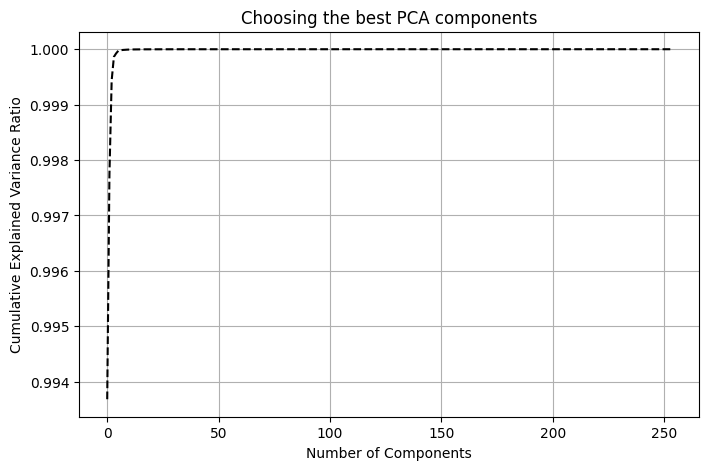

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.cumsum(pca.explained_variance_ratio_), linestyle="--", color="k")
ax.set(xlabel="Number of Components", ylabel="Cumulative Explained Variance Ratio", title="Choosing the best PCA components")
ax.grid()
plt.show()

### Interpreting PCA

In [16]:
pca_1 = PCA(n_components=1, random_state=42)
pca_1.fit(jury_conv.drop(columns_to_ignore, axis=1))
juries_transformed = pca_1.transform(jury_conv.drop(columns_to_ignore, axis=1))
juries_inv_transformed = pca_1.inverse_transform(juries_transformed)

reconstruction_error = np.sqrt(mean_squared_error(y_true = jury_conv.drop(columns_to_ignore, axis=1).to_numpy(), y_pred = juries_inv_transformed))
print("Reconstruction Error:", round(reconstruction_error, 3))

Reconstruction Error: 29.09


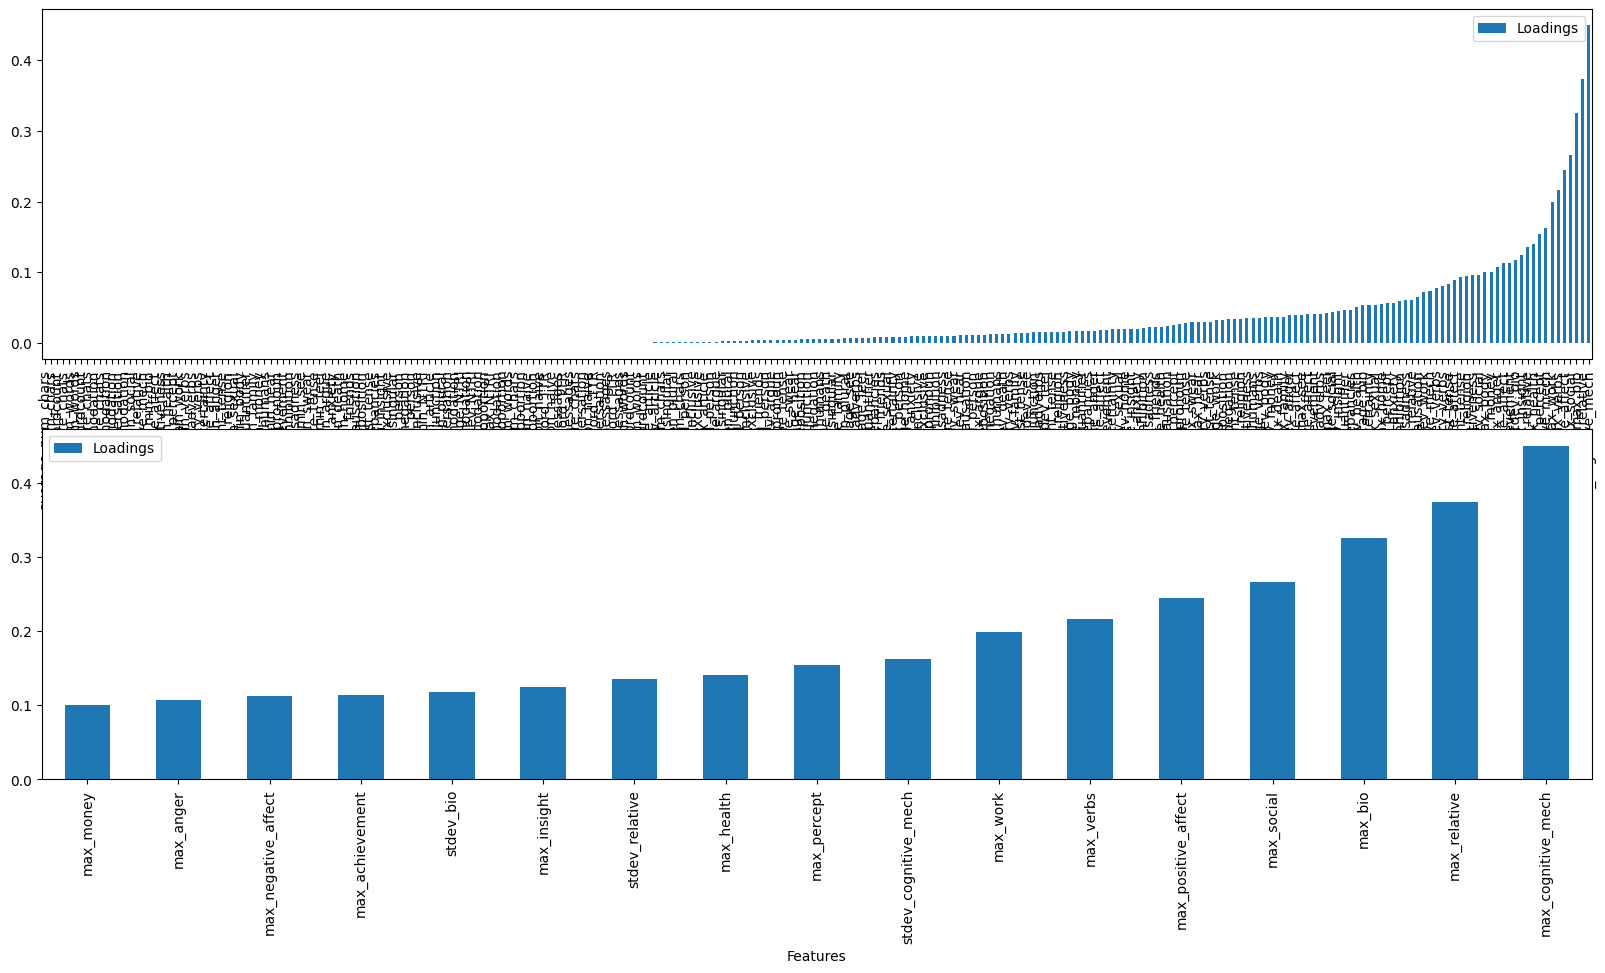

In [32]:
components_df = pd.DataFrame({"Loadings": list(pca_1.components_[0]), "Features": jury_conv.drop(columns_to_ignore, axis=1).columns})
components_df.sort_values(by=["Loadings"], ascending=[True], inplace=True)
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
components_df.plot.bar(x="Features", y="Loadings", ax=ax[0])
components_df[components_df["Loadings"]>0.1].plot.bar(x="Features", y="Loadings", ax=ax[1])
plt.show()

In [33]:
components_df.to_csv("pca_components.csv", index=False)

## t-SNE

In [7]:
tsne = TSNE(random_state=42, n_components=2, perplexity=30)
tsne.fit(jury_conv.drop(columns_to_ignore, axis=1))

TSNE(perplexity=30, random_state=42)

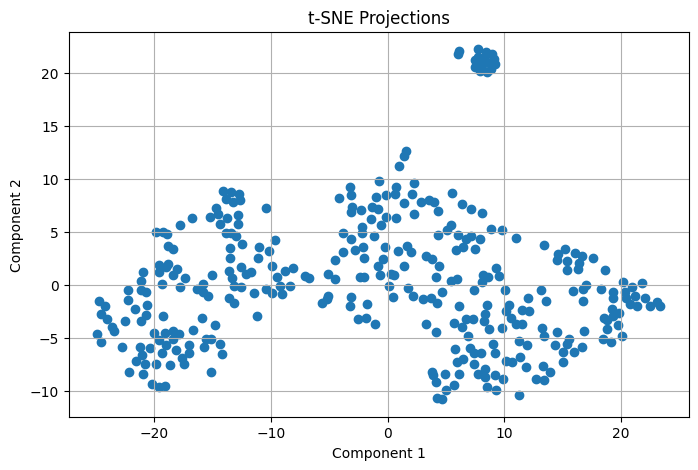

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1])
ax.set(xlabel="Component 1", ylabel="Component 2", title="t-SNE Projections")
ax.grid()
plt.show()

# Clustering

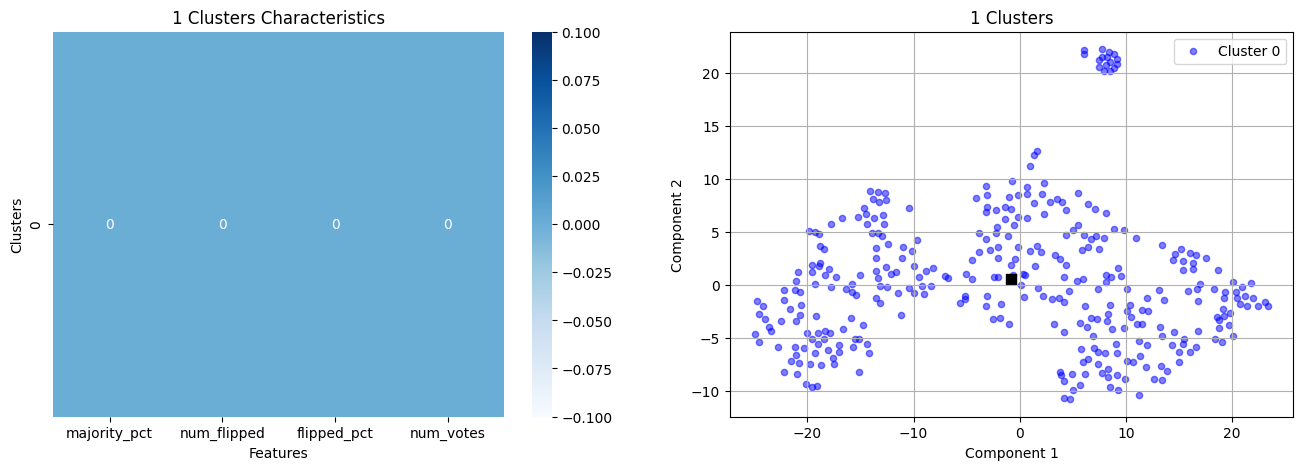

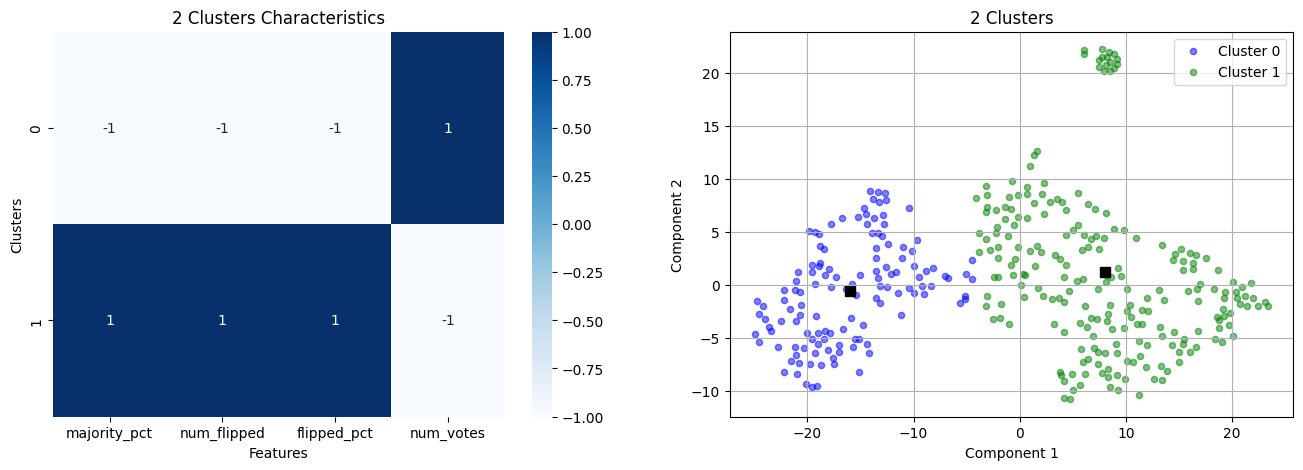

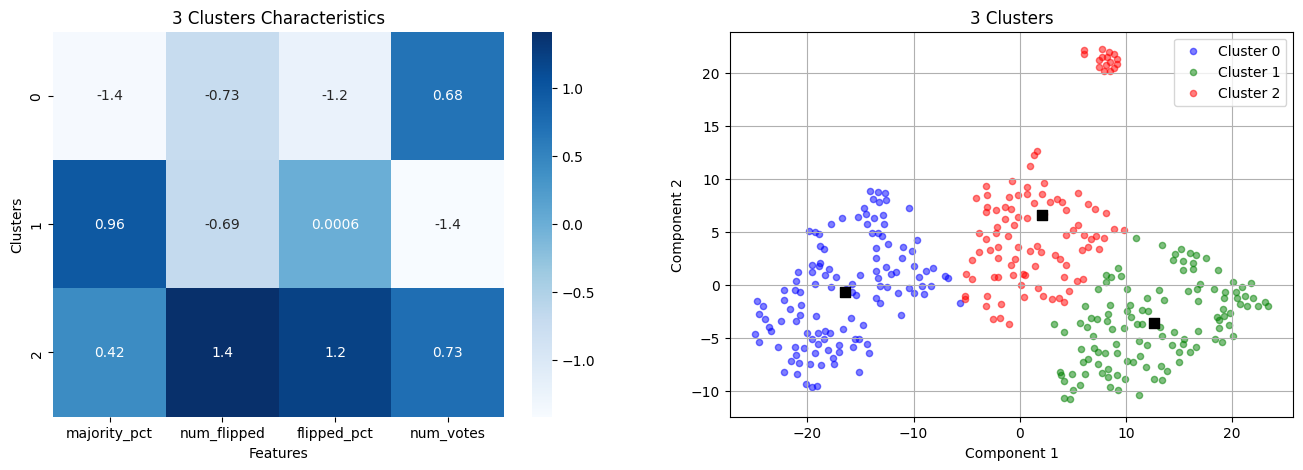

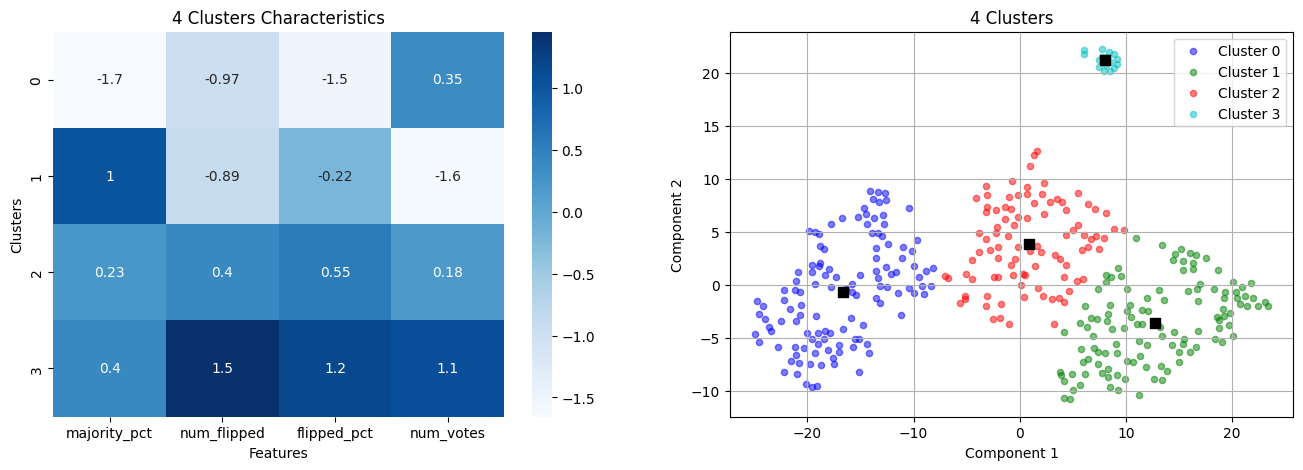

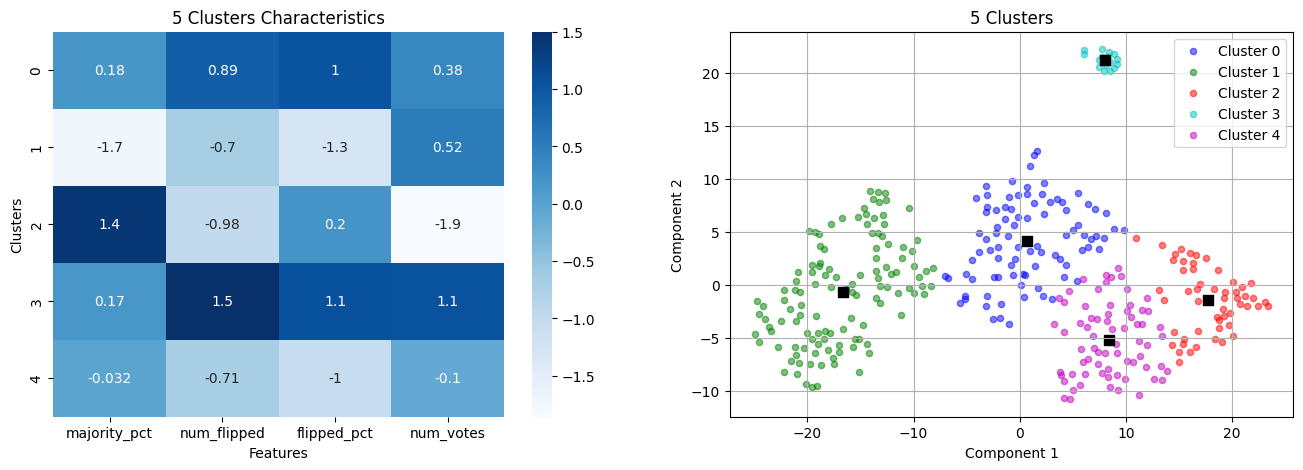

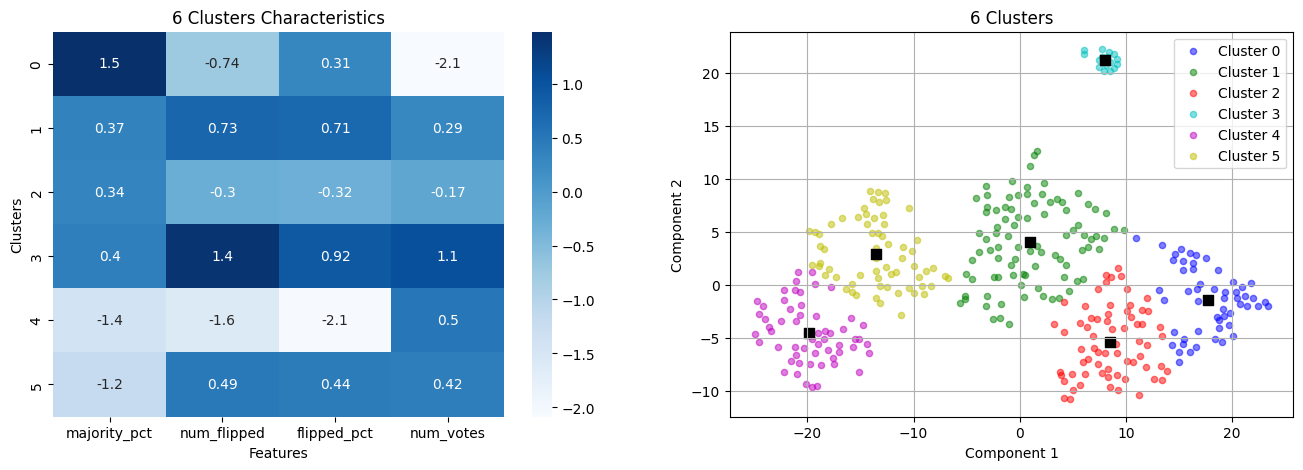

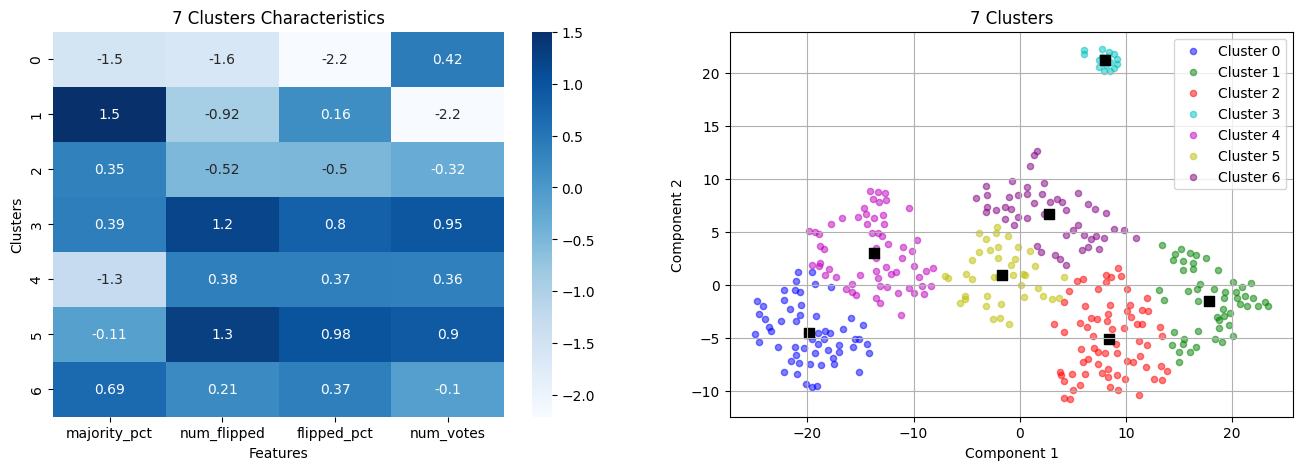

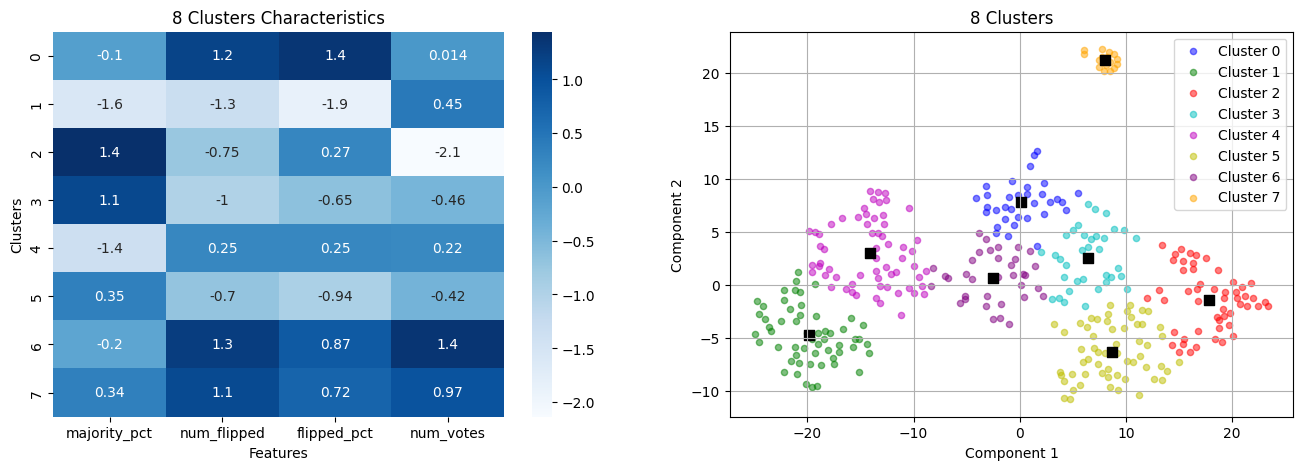

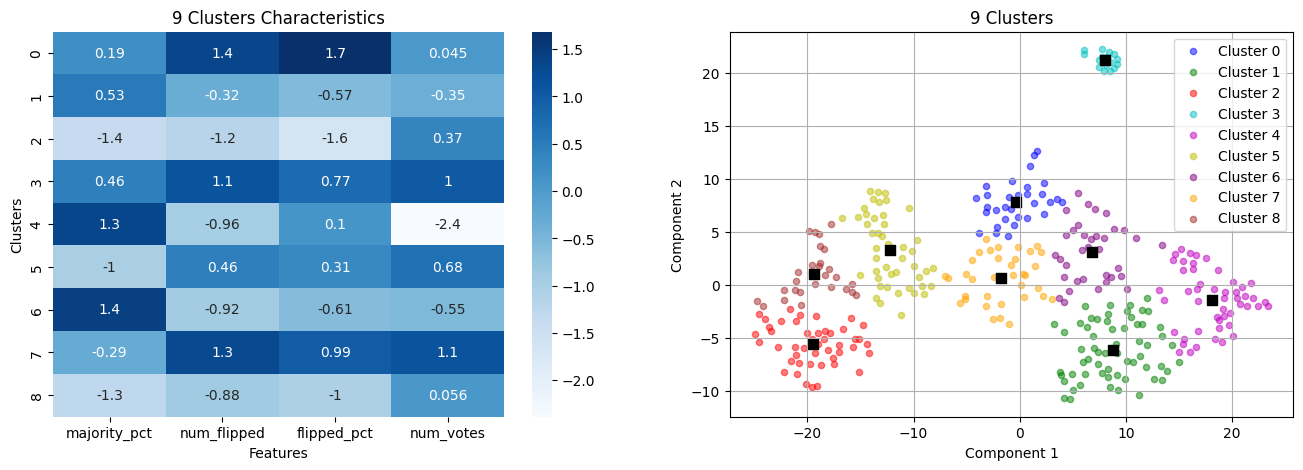

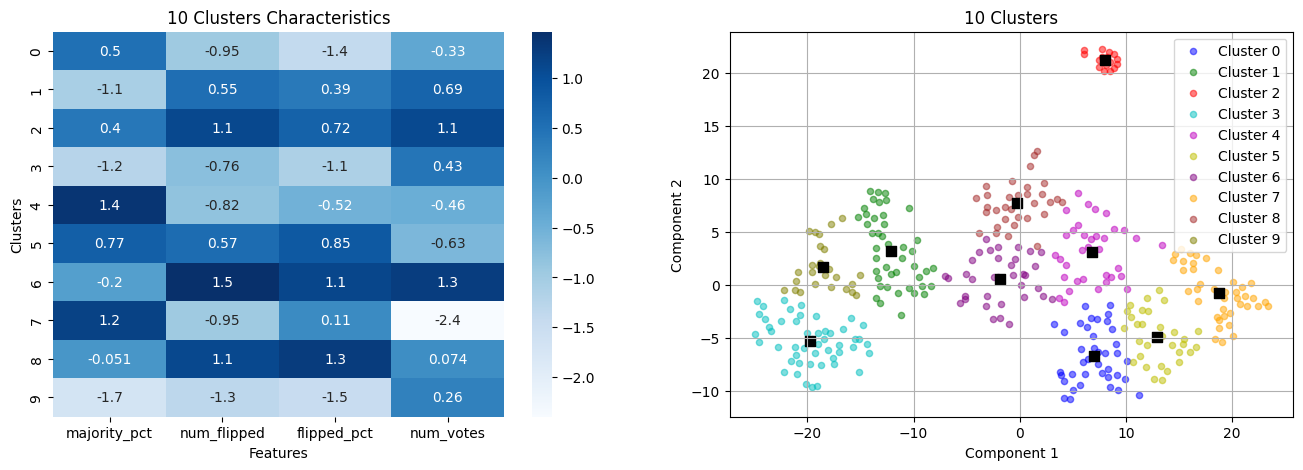

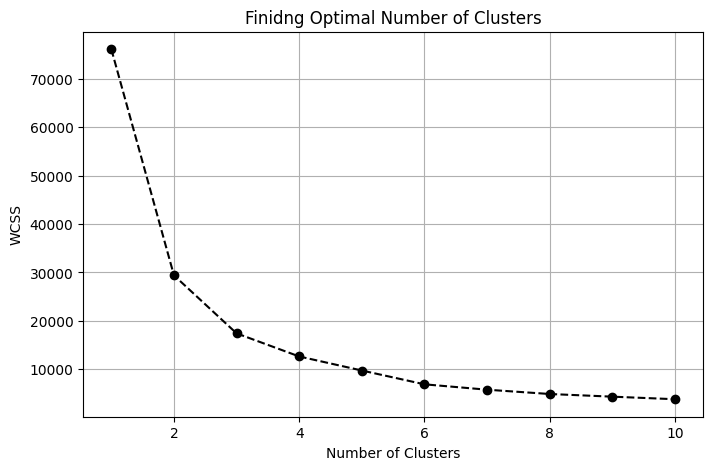

In [9]:
inertias = []
for k in range(1, 11):
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tsne.embedding_)
    inertias.append(kmeans.inertia_)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    # Plot 1 - Cluster Summary
    scaler = StandardScaler()
    summary_df = jury_conv.copy()
    summary_df["Cluster"] = kmeans.labels_
    cluster_summary_df = pd.DataFrame(
        scaler.fit_transform(
            summary_df.groupby(by=["Cluster"])[['majority_pct', 'num_flipped', 'flipped_pct', 'num_votes']].mean()
        ),
        columns = ['majority_pct', 'num_flipped', 'flipped_pct', 'num_votes']
    )
    sns.heatmap(cluster_summary_df, annot=True, cmap="Blues", ax=ax[0])
    ax[0].set(xlabel="Features", ylabel="Clusters", title=f"{k} Clusters Characteristics")
    
    # Plot 2 - Cluster Distribution
    cluster_df = pd.DataFrame({"C1": tsne.embedding_[:, 0], "C2": tsne.embedding_[:, 1], "Cluster": kmeans.labels_})
    colors = ["b", "g", "r", "c", "m", "y", "purple", "orange", "brown", "olive"]
    for cluster in range(0, k):
        cluster_df[cluster_df["Cluster"]==cluster].plot.scatter(
            x="C1", y="C2", ax=ax[1], label=f"Cluster {cluster}", color=colors[cluster], alpha=0.5
        )
    ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color="k", marker="s", s=50)
    ax[1].set(xlabel="Component 1", ylabel="Component 2", title=f"{k} Clusters")
    ax[1].grid()
    
    plt.show()

# Elbow Plot for Optimal Number of KMeans Clusters
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(1, 11)), inertias, marker="o", linestyle="--", color="k")
ax.set(xlabel="Number of Clusters", ylabel="WCSS", title="Finidng Optimal Number of Clusters")
ax.grid()
plt.show()

# Baseline Model

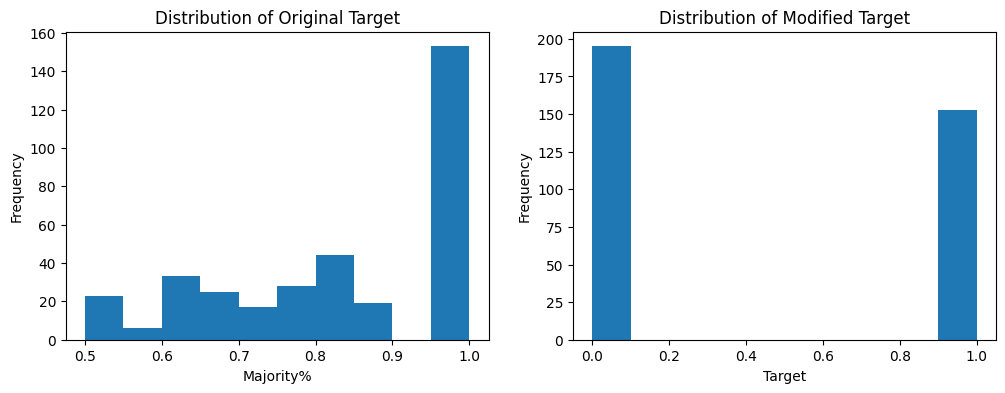

In [15]:
target = (jury_conv["majority_pct"]==1).astype(int)
data = jury_conv.drop(columns_to_ignore, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(jury_conv["majority_pct"])
ax[0].set(xlabel="Majority%", ylabel="Frequency", title="Distribution of Original Target")
ax[1].hist(target)
ax[1].set(xlabel="Target", ylabel="Frequency", title="Distribution of Modified Target")
plt.show()

In [22]:
X, y = data.to_numpy(), target.to_numpy()
rf = RandomForestClassifier(random_state=42)
accuracy = cross_val_score(estimator=rf, X=X, y=y, scoring="accuracy").mean().round(4)
print("Cross Validation (5 Fold) Accuracy:", accuracy)
f1 = cross_val_score(estimator=rf, X=X, y=y, scoring="f1").mean().round(4)
print("Cross Validation (5 Fold) F1:", f1)

Cross Validation (5 Fold) Accuracy: 0.5402
Cross Validation (5 Fold) F1: 0.3988


In [31]:
preds = cross_val_predict(estimator=rf, X=X, y=y)
probs = cross_val_predict(estimator=rf, X=X, y=y, method="predict_proba")[:, 1]

In [41]:
precision, recall, pr_thresholds = precision_recall_curve(y_true=y, probas_pred=probs)
pr_df = pd.DataFrame({"Precision": precision, "Recall": recall, "Thresholds": list(pr_thresholds)+[np.nan]})

auroc = roc_auc_score(y_true=y, y_score=probs).round(4)
fpr, tpr, roc_thresholds = roc_curve(y_true=y, y_score=probs)
roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr, "Thresholds": roc_thresholds})

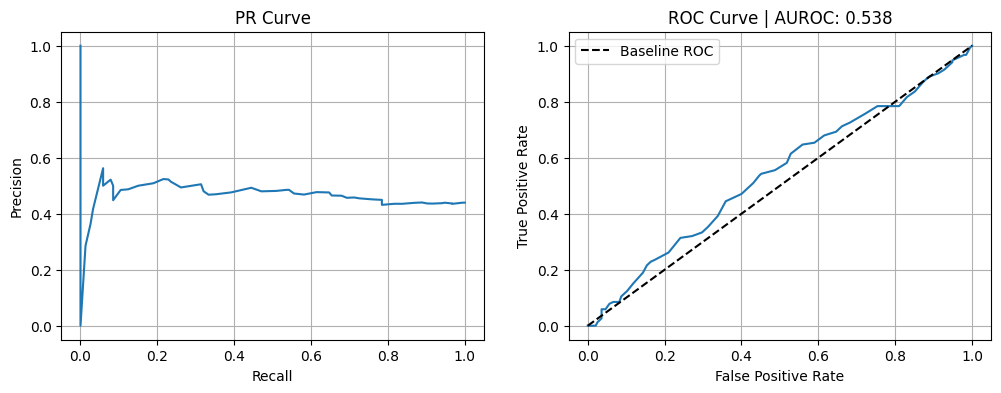

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(pr_df["Recall"], pr_df["Precision"])
ax[0].set(xlabel="Recall", ylabel="Precision", title=f"PR Curve")
ax[0].grid()

ax[1].plot(roc_df["FPR"], roc_df["TPR"])
ax[1].plot([0, 1], [0, 1], linestyle="--", color="k", label="Baseline ROC")
ax[1].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=f"ROC Curve | AUROC: {auroc}")
ax[1].grid()
ax[1].legend()

plt.show()